In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
%ls

Classification.ipynb     cats_vs_dogs.ipynb       test1/
HandRight.csv            fashion-mnist_test.csv   test1.zip
HandsSync.ipynb          fashion-mnist_train.csv  train/
HandsTraining/           fmnist.ipynb             train.zip
HandsValidation/         models/                  winequality-red.csv
README.md                sampleSubmission.csv


# Are the Hands in sync ?

<div>
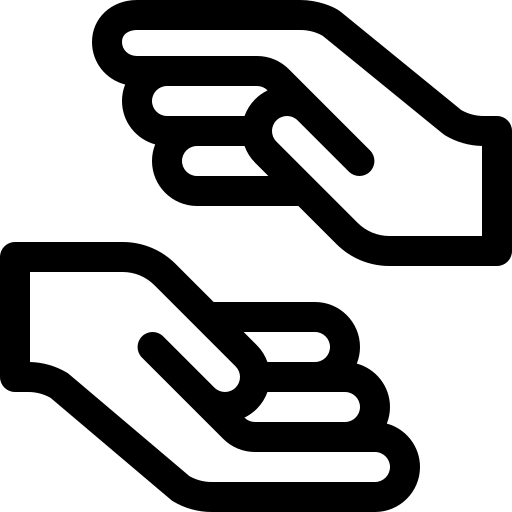
</div>


Hey, this notebook is about checking whether we can predict if the person is moving their hands spotanously in sync with someone or alone

The instruction that were given for the data pre processing:

1. in the directories with duplicate files delete the files that appear first
2. load the righthand data and merge it with each `alone` dataset 
3. creates labels and try to predict the state of the hands

In [3]:
rightHandData = pd.read_csv('./HandRight.csv')
rightHandData.columns = rightHandData.columns.str.strip()
rightHandData

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.671670,226.2064,20.264700,34.26665,-195.214700,-35.043020,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.241190,222.9389,20.117810,36.16443,-180.093900,-4.052799,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.724610,220.9709,19.949720,26.35298,-95.088190,-11.157620,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.090160,219.7124,19.676790,19.46804,-61.755180,-21.303780,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.460170,219.3652,19.131280,21.94964,-8.355943,-35.081790,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,208.1942,24687,right,1,-15.404800,208.0276,9.980799,167.86240,510.085200,-105.529500,...,-0.282299,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.503490,0.0
4808,208.2108,24689,right,1,-12.678650,218.1196,9.314082,145.00970,562.359400,-20.707010,...,-0.263492,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.403687,0.0
4809,208.2276,24691,right,1,-9.643562,228.2807,9.722980,180.42160,591.901900,28.880570,...,-0.234336,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.310940,0.0
4810,208.2443,24692,right,1,-7.980715,233.5056,10.419080,192.45930,604.734400,80.566980,...,-0.222084,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.286526,0.0


In [4]:
# as we were told we need to get rid of the first 7 seconds
def clean_initial_data(df):
    firsrtTimestamp = df.head(1)["Time"][0]
    df.drop(df[df.Time < firsrtTimestamp+7].index, inplace=True)



In [5]:
clean_initial_data(rightHandData)
rightHandData.drop(rightHandData[rightHandData["Hand Type"]=='left'].index, inplace=True)
rightHandData.drop(['# hands'], axis=1, inplace=True)
rightHandData.reset_index(drop=True)
rightHandData["Hand Type"].value_counts()

right    4317
Name: Hand Type, dtype: int64

In [6]:
rightHandData.dropna(inplace=True)
rightHandData.isnull().sum(axis = 0)

Time              0
Frame ID          0
Hand Type         0
Position X        0
Position Y        0
Position Z        0
Velocity X        0
Velocity Y        0
Velocity Z        0
Pitch             0
Roll              0
Yaw               0
Wrist Pos X       0
Wrist Pos Y       0
Wrist Pos Z       0
Elbow pos X       0
Elbow Pos Y       0
Elbow Pos Z       0
Grab Strenth      0
Grab Angle        0
Pinch Strength    0
dtype: int64

In [7]:
# get 15% percent of the righthand data to be used as test data 
data_percentile = round(len(rightHandData) * 0.2)

separated_test_data = pd.DataFrame.copy(rightHandData.iloc[-data_percentile:])

rightHandData = pd.DataFrame.copy(rightHandData.iloc[:-data_percentile])

rightHandData

,Time,Frame ID,Hand Type,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
421,135.3024,16287,right,11.930320,199.9861,4.981665,-35.512210,-165.34660,-57.68153,-0.092033,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.016700,201.9318,0.0,0.561324,0.0
422,135.3194,16289,right,11.191900,195.3075,3.661716,-43.587440,-309.83740,-77.18515,-0.111674,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.971200,203.6773,0.0,0.626321,0.0
423,135.3357,16291,right,10.533080,189.0297,2.829388,-30.403600,-363.00330,-43.79815,-0.140004,...,-0.901862,73.60060,197.4387,43.54082,280.6384,142.540100,206.7526,0.0,0.636596,0.0
424,135.3524,16293,right,10.243000,181.9816,2.064330,-15.424000,-423.21200,-43.99948,-0.166623,...,-0.901268,73.19537,191.7202,42.73155,279.7357,148.138200,209.9330,0.0,0.701644,0.0
425,135.3690,16295,right,10.020610,174.8592,1.228467,-8.733602,-413.45130,-53.88054,-0.197763,...,-0.897777,72.68671,186.1613,41.98006,278.6890,152.521500,212.1112,0.0,0.786548,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3602,187.9682,22358,right,15.011520,227.8607,-3.997064,-98.245350,197.21200,319.55200,1.111313,...,-0.046356,28.75041,164.1245,36.46899,136.5801,1.873683,226.2796,0.0,0.534085,0.0
3603,187.9847,22360,right,12.565540,232.2578,-1.452736,-185.950000,224.99400,77.43333,1.191593,...,-0.134248,27.88593,166.7243,35.27282,138.2208,9.605652,227.9398,0.0,0.509543,0.0
3604,188.0015,22362,right,9.757510,234.7574,-0.994918,-139.169100,74.02553,41.39766,1.210409,...,-0.233767,27.12279,169.1516,34.70261,139.2601,11.057680,225.5223,0.0,0.457348,0.0
3605,188.0176,22364,right,7.025321,234.3546,-0.467190,-150.620900,35.70984,38.94785,1.180323,...,-0.264282,26.00730,169.8926,36.53437,144.7947,13.031930,224.3239,0.0,0.436348,0.0


## The labels of each type are as follows:

Alone: 0

Sync: 1

Spontan: 2

In [8]:
def multiplydata(df, target_size):
    while df.index.size < target_size:
        data_copy = df.copy()
        df = df.append(data_copy)

    df = df.reset_index(drop=True)
    df = df.truncate(after=target_size-1)
    return df

    

In [9]:
def prep_alone_data(df,right_hand_df):
    combined_df = pd.DataFrame()
    right_hand_copy = right_hand_df.copy()
    
    df.drop(df[df["Hand Type"]=='right'].index, inplace=True)
    min_index_val = min(df.index.size, right_hand_copy.index.size)
    max_index_val = max(df.index.size, right_hand_copy.index.size)

    
    if right_hand_copy.index.size == min_index_val:
        right_hand_copy = multiplydata(right_hand_copy,max_index_val)
        df = df.reset_index(drop=True)
        right_hand_copy["Frame ID"] = df["Frame ID"]
        right_hand_copy["Time"] = df["Time"]
    else:
        df = multiplydata(df,max_index_val)
        right_hand_copy = right_hand_copy.reset_index(drop=True)
        df["Frame ID"] = right_hand_copy["Frame ID"]
        df["Time"] = right_hand_copy["Time"]

    
    combined_df = right_hand_copy.append(df)

    return combined_df

In [10]:
# this function clears the data for the multi hand scenarios (sync/spontan) 
def prep_multihand_data(df):
    df.drop(df[df["# hands"]==1].index, inplace=True)

In [11]:

def get_df_list(path_to_scan,right_hand_df):   
    csv_train_data_list = []
    for filename in glob.iglob(path_to_scan, recursive=True):

        cleansed_name = filename.split('/')[-1].split('.')[0].lower()

        data = pd.read_csv(filename)
        data.columns = data.columns.str.strip()
        clean_initial_data(data)


        if 'alone' in cleansed_name:
            data = prep_alone_data(data, right_hand_df)
            data['type'] = 0

        if 'sync' in cleansed_name:
            prep_multihand_data(data)
            data['type'] = 1

        if 'spontan' in cleansed_name:
            prep_multihand_data(data)
            data['type'] = 2

        data.drop(['# hands'], axis=1, inplace=True)
        csv_train_data_list.append(data)
    return csv_train_data_list

### clearing these columns for each dataframe since they don't give us any value

In [12]:
csv_data_list = get_df_list('./HandsTraining/**/*.csv',rightHandData)

In [13]:
to_clear = {'Frame ID', 'type'}

def clear_columns(df):
    for column_name in df:
        column_prefix = column_name.split('_')[0]
        if column_prefix in to_clear:
            df[column_prefix] = df[column_name]
            df.drop([column_name], axis=1, inplace=True)

## This section contains data flattening and preparation for ML

### this function is meant to flatten the data after the groupby operation so that we have the right and left hand data on the same row

In [14]:

cleansed_data = []

def flatten_data(data):
    data["Time"]= data["Time"].round(1)
    # the mean have doesn't affect the type because the type remains the same in in dataframe
    temp_df = data.groupby(["Time","Hand Type"]).mean().unstack()
    temp_df.columns = [f"{x}_{y}" for x, y in temp_df.columns.to_flat_index()]
    clear_columns(temp_df)
    temp_df = temp_df.reset_index()

    return temp_df


for data in csv_data_list:
    cleansed_data.append(flatten_data(data))



### The custom split train test 

we are going to take the last 7 seconds of each dataframe and remove the initial 2 seconds. This is how we are creating a validation set

In [15]:
def split_label_from_data(df, label_column):
    label = df[label_column]
    data_without_label = df.drop([label_column], axis=1)
    
    return data_without_label, label

def custom_split_train_test():
    validation_set = pd.DataFrame()
    train_set = pd.DataFrame()
    for clean_df in cleansed_data:
        sorted_by_time = clean_df.sort_values(by=["Time"])
        last_timestamp = sorted_by_time.iloc[-1]["Time"]
        chunk_start_timestamp = last_timestamp - 7
        
        train_set = train_set.append(sorted_by_time[sorted_by_time["Time"]< chunk_start_timestamp])
        validation_set = validation_set.append(sorted_by_time[sorted_by_time["Time"]> chunk_start_timestamp +2 ])
        
    train_set.drop(['Time','Frame ID'], axis=1, inplace=True)
    validation_set.drop(['Time','Frame ID'], axis=1, inplace=True)
    return train_set, validation_set



In [16]:
trainush, testush = custom_split_train_test()

x_train, x_train_label = split_label_from_data(trainush, 'type')
x_test, x_test_label = split_label_from_data(testush,'type')


print(len(x_train))
print(len(x_test))

15952
1349


In [17]:

def combine_data_to_df(cleansed_dfs, is_column_clearing_req = True):
    combined_data = pd.DataFrame()
    for clean_df in cleansed_dfs:
        if is_column_clearing_req:
            clean_df.drop(['Time','Frame ID'], axis=1, inplace=True)
        combined_data = combined_data.append(clean_df)
    return combined_data

combined_train_data = combine_data_to_df(cleansed_data, False)

In [18]:
combined_train_data

,Time,Position X_left,Position X_right,Position Y_left,Position Y_right,Position Z_left,Position Z_right,Velocity X_left,Velocity X_right,Velocity Y_left,...,Elbow Pos Z_left,Elbow Pos Z_right,Grab Strenth_left,Grab Strenth_right,Grab Angle_left,Grab Angle_right,Pinch Strength_left,Pinch Strength_right,Frame ID,type
0,619.9,-124.681450,11.561110,166.837700,197.646800,-25.574470,4.321691,194.423550,-39.549825,-249.242700,...,87.618940,202.804550,0.0,0.0,0.000000,0.593823,0.000000,0.0,71526.000000,0.0
1,620.0,-115.310050,10.209380,152.793450,172.031200,-14.160583,0.638263,95.075588,-4.644668,-167.887027,...,79.760710,211.924083,0.0,0.0,0.050559,0.768237,0.000000,0.0,71533.666667,0.0
2,620.1,-109.949383,8.626778,139.722283,154.246550,2.709800,-6.222635,52.171855,-39.175324,-95.256782,...,57.838243,215.539550,0.0,0.0,0.573307,0.718056,0.000000,0.0,71545.000000,0.0
3,620.2,-115.441483,2.352101,145.256700,188.948050,12.352832,-15.967013,-143.463750,-65.219663,208.301317,...,89.408805,199.844233,0.0,0.0,0.529309,0.357901,0.000747,0.0,71556.500000,0.0
4,620.3,-130.614367,-3.693207,177.284750,239.023750,18.280183,-20.750805,-139.783617,-52.908467,380.105967,...,42.929602,202.464067,0.0,0.0,0.583676,0.172504,0.000712,0.0,71568.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,250.1,-198.987000,166.109617,181.164167,184.872950,-80.753918,-27.605060,-11.412688,26.982141,39.739050,...,66.799632,126.703983,0.0,0.0,0.521760,0.384707,0.000000,0.0,29363.000000,2.0
633,250.2,-200.089767,167.504000,187.099617,178.430967,-83.680662,-34.788708,-16.004239,-11.292834,50.922641,...,61.245275,141.335217,0.0,0.0,0.721463,0.227848,0.000000,0.0,29374.666667,2.0
634,250.3,-195.758933,163.143517,185.294317,195.470583,-82.830697,-36.751572,96.248723,-21.844180,-86.241338,...,64.583177,142.098183,0.0,0.0,1.477636,0.226353,0.385784,0.0,29386.000000,2.0
635,250.4,-185.761867,170.257500,170.477767,236.062333,-73.600487,-20.925784,76.909097,205.185617,-178.157183,...,78.049700,130.935500,0.0,0.0,2.225180,0.162181,0.866010,0.0,29397.333333,2.0


## Let's Visualize 

In [19]:
corr_dec = combined_train_data.corr()["type"].sort_values(ascending=False)
corr_dec = corr_dec.where(lambda x : np.abs(x)>0.2).dropna()
corr_dec = corr_dec.where(lambda x : np.abs(x)<1).dropna()
corr_dec

Wrist Pos X_right    0.824526
Elbow pos X_right    0.795831
Position X_right     0.762629
Pitch_right          0.238675
Roll_right          -0.250648
Position X_left     -0.285734
Wrist Pos X_left    -0.299535
Wrist Pos Z_right   -0.340973
Yaw_right           -0.535957
Elbow Pos Z_right   -0.671726
Name: type, dtype: float64

In [20]:
plots_size = (14, 5)

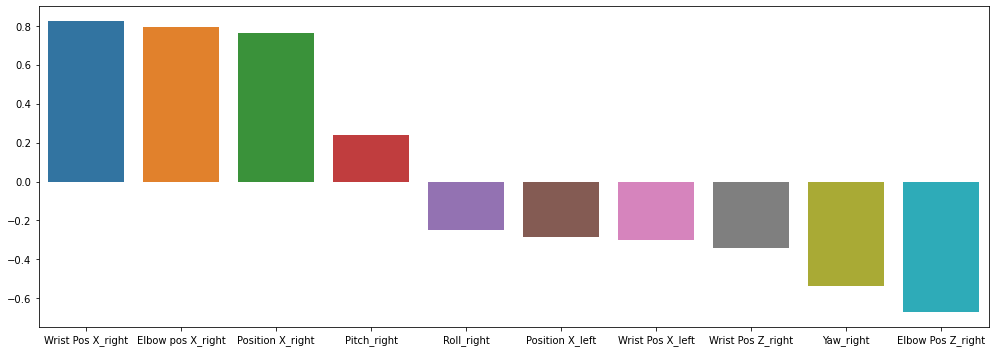

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(plots_size)
sns.barplot(x=corr_dec.index, y=corr_dec.values,ax=ax)
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Right hand wrist position over time, per type'}, xlabel='Time', ylabel='Wrist Pos X_right'>

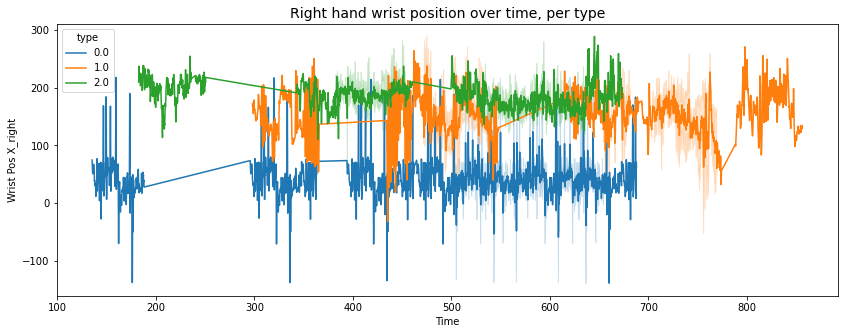

In [22]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(plots_size)
ax.set_title('Right hand wrist position over time, per type', fontsize=14)
sns.lineplot(data=combined_train_data, y='Wrist Pos X_right',x='Time', hue='type', palette='tab10')

<AxesSubplot:title={'center':'Right hand elbow position on the X axis, per type'}, xlabel='Time', ylabel='Elbow pos X_right'>

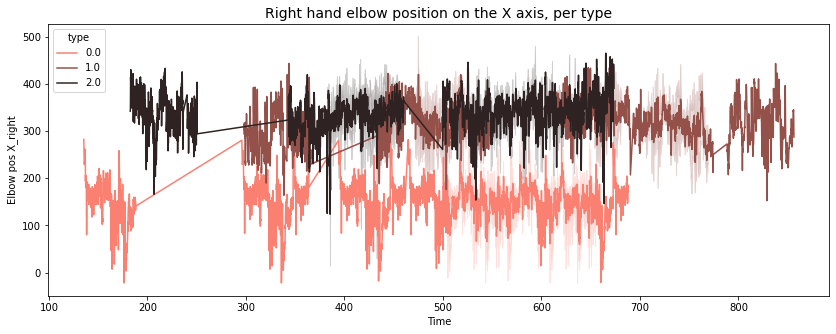

In [23]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(plots_size)
ax.set_title('Right hand elbow position on the X axis, per type', fontsize=14)
sns.lineplot(data=combined_train_data, y='Elbow pos X_right',x='Time', hue='type', palette='dark:salmon_r')

<AxesSubplot:title={'center':'Right hand elbow position over time on the Z axis, per type'}, xlabel='Time', ylabel='Elbow Pos Z_right'>

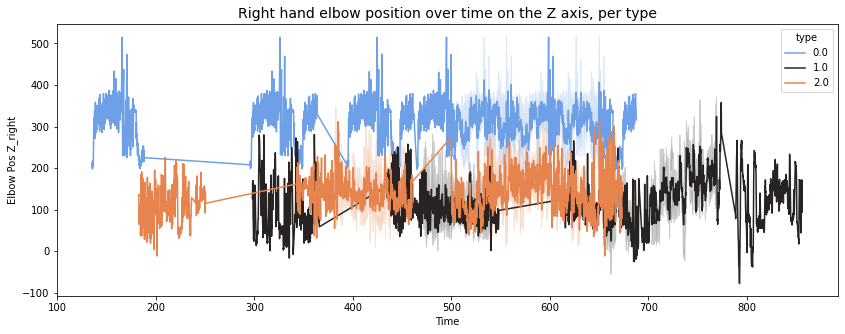

In [24]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(plots_size)
ax.set_title('Right hand elbow position over time on the Z axis, per type', fontsize=14)
sns.lineplot(data=combined_train_data, y='Elbow Pos Z_right',x='Time', hue='type', palette=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True))

<AxesSubplot:title={'center':'Right hand yaw, per type'}, xlabel='Time', ylabel='Yaw_right'>

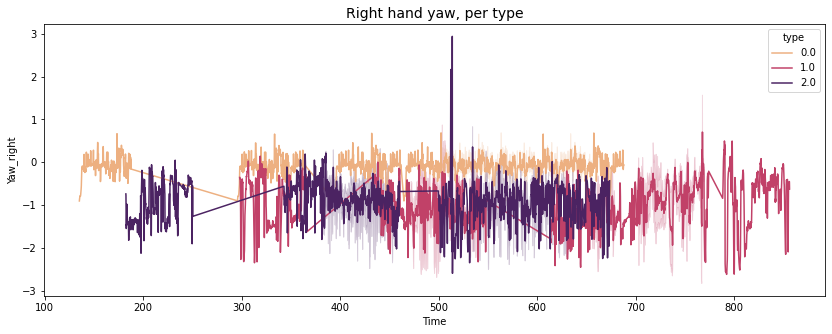

In [25]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(plots_size)
ax.set_title('Right hand yaw, per type', fontsize=14)
sns.lineplot(data=combined_train_data, y='Yaw_right',x='Time', hue='type', palette=sns.color_palette("flare", as_cmap=True))

--------------------

## Training the models and validating it against a validation set 


I have decided to drop the `'Time','Frame ID'` columns since they have a very low correlation as we have seen above, furthermore we have merged the data using those columns they won't benefit the models

In [26]:

combined_train_data.drop(['Time','Frame ID'], axis=1, inplace=True)
print(combined_train_data["type"].value_counts())
label = combined_train_data["type"]
data_without_label = combined_train_data.drop(['type'], axis=1)

2.0    6002
1.0    5998
0.0    5868
Name: type, dtype: int64


In [27]:
knn_cls = KNeighborsClassifier()
knn_cls.fit(x_train, x_train_label)
knn_cls.score(x_test, x_test_label)

0.9073387694588584

In [28]:
forest_clf = RandomForestClassifier(random_state=0, n_jobs=-1)


forest_clf.fit(x_train, x_train_label)
forest_clf.score(x_test, x_test_label)

0.9214232765011119

## Comparing feature importance against the correlation

In [29]:
forest_clf.feature_importances_

importance_df = pd.DataFrame(list(zip(list(x_train.columns),forest_clf.feature_importances_,combined_train_data.corr()["type"])),
                             columns = ['feature_name', 'importance','corr'])

print(importance_df.sort_values(by=['corr'],ascending=False))

            feature_name  importance      corr
19     Wrist Pos X_right    0.145022  0.824526
25     Elbow pos X_right    0.131491  0.795831
1       Position X_right    0.107356  0.762629
13           Pitch_right    0.035049  0.238675
22      Wrist Pos Z_left    0.019867  0.197721
28      Elbow Pos Z_left    0.023799  0.182042
4        Position Z_left    0.016465  0.166933
3       Position Y_right    0.008940  0.131157
21     Wrist Pos Y_right    0.011750  0.098023
16              Yaw_left    0.012040  0.033167
12            Pitch_left    0.011715  0.032778
14             Roll_left    0.047866  0.029419
9       Velocity Y_right    0.004485  0.000636
6        Velocity X_left    0.004977 -0.000460
11      Velocity Z_right    0.005866 -0.000671
8        Velocity Y_left    0.004298 -0.001202
10       Velocity Z_left    0.004382 -0.003663
7       Velocity X_right    0.006922 -0.004548
34   Pinch Strength_left    0.006530 -0.020463
31    Grab Strenth_right    0.002237 -0.020718
32       Grab

In [30]:
xgb_cls = XGBClassifier()

xgb_cls.fit(x_train, x_train_label)
xgb_cls.score(x_test, x_test_label)

0.9399555226093402

## Loading given test data to see if the models meet our expectations

In [31]:
csv_test_data_list = get_df_list('./HandsValidation//**/*.csv',separated_test_data)

clean_test_data = []
for data in csv_test_data_list:
    clean_test_data.append(flatten_data(data))
    

combined_test_data = combine_data_to_df(clean_test_data )

print(combined_test_data["type"].value_counts())
test_label = combined_test_data["type"]
test_data_without_label = combined_test_data.drop(['type'], axis=1)

2.0    2033
0.0    2032
1.0    1990
Name: type, dtype: int64


In [32]:
knn_cls = KNeighborsClassifier()
knn_cls.fit(data_without_label,label)
knn_cls.score(test_data_without_label, test_label)

0.8218001651527663

In [33]:
forest_clf = RandomForestClassifier(random_state=0,n_estimators=200, n_jobs=-1)


forest_clf.fit(data_without_label,label)
forest_clf.score(test_data_without_label, test_label)

0.8356729975227085

In [34]:
xgb_cls = XGBClassifier()

xgb_cls.fit(data_without_label,label)
xgb_cls.score(test_data_without_label, test_label)

0.8530140379851362